# Analyzing and classification of electrical bearing faults

### Importing the libraries 

In [1]:
#import the neccesary libraries
import pandas as pd
import numpy as np
from scipy.stats import kurtosis, skew
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

C:\Users\ampad\anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ampad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\ampad\anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


### Loading the datasets

In [2]:
signals_data = np.load('raw_signal_data.npy')
signals_label = np.load('Featurized_data_labels.npy')

In [3]:
print('The shape of the signals data is:',signals_data.shape)
print('The shape of the signals label is:',signals_label.shape)

The shape of the signals data is: (58000, 2500)
The shape of the signals label is: (2319,)


#### The signals data has a lot of components, and a lot of noise, so the neccesary features have to be extracted using various methods and processes

### Feature Extraction

In [4]:
#function to extract the features
def feature_extract(skew,kurtosis):
    mean = signals_data.mean(axis=0)
    max = signals_data.max(axis=0)
    min = signals_data.min(axis=0)
    kurtosis = kurtosis(signals_data)
    skew = skew(signals_data)
    var = (signals_data.std(axis=0))**2
    rms = np.sqrt(np.mean(signals_data**2,axis=0))
    abs_mean = np.abs(signals_data).mean(axis=0)
    abs_max = np.abs(signals_data.max(axis=0))
    crest_factor = abs_max/rms
    impulse_factor = abs_max/abs_mean
    shape_factor = rms/abs_mean
    peak2peak = max-min
    num = signals_data
    abs_num = np.abs(num)
    n_num = np.sqrt(abs_num)
    n = len(n_num)
    get_sum = sum(n_num)
    mean_clr = get_sum / n
    clearance_factor = abs_max/mean_clr
    signals_dataframe = pd.DataFrame({'kurtosis':kurtosis,'skewness':skew,'mean':mean,'max':max,'min':min,'var':var,'rms':rms,'absolute_mean':abs_mean,
             'absolute_max':abs_max,'crest_factor':crest_factor,'impulse_factor':impulse_factor,'shape_factor':shape_factor,
             'peak2peak':peak2peak,'clearance_factor':clearance_factor})
    return signals_dataframe

In [5]:
feature_extract(skew,kurtosis)

,kurtosis,skewness,mean,max,min,var,rms,absolute_mean,absolute_max,crest_factor,impulse_factor,shape_factor,peak2peak,clearance_factor
0,13.450874,0.439993,0.007858,4.693604,-3.173828,0.099814,0.316031,0.208981,4.693604,14.851696,22.459446,1.512248,7.867432,11.584797
1,12.542990,0.244899,0.007485,4.226685,-3.692627,0.099501,0.315526,0.208354,4.226685,13.395663,20.286076,1.514376,7.919312,10.451219
2,12.963039,0.376136,0.009260,4.666138,-3.588867,0.101620,0.318914,0.210126,4.666138,14.631332,22.206391,1.517729,8.255005,11.503992
3,13.835701,0.388004,0.008410,4.632568,-3.250122,0.102093,0.319631,0.209859,4.632568,14.493499,22.074625,1.523071,7.882690,11.428709
4,14.406844,0.347763,0.008809,4.974365,-3.683472,0.100386,0.316960,0.208705,4.974365,15.693982,23.834411,1.518697,8.657837,12.303071
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,14.465873,0.488464,0.007494,4.721069,-3.048706,0.105361,0.324680,0.212755,4.721069,14.540665,22.190143,1.526075,7.769775,11.575438
2496,14.612368,0.210669,0.006581,5.484009,-3.561401,0.104272,0.322979,0.212209,5.484009,16.979457,25.842479,1.521985,9.045410,13.453323
2497,14.159956,0.484434,0.009163,4.571533,-3.421021,0.102815,0.320778,0.210615,4.571533,14.251377,21.705611,1.523054,7.992554,11.260201
2498,15.681832,0.310999,0.007093,5.429077,-3.613281,0.104123,0.322758,0.210887,5.429077,16.820868,25.743986,1.530479,9.042358,13.374361


In [6]:
new_signals_data = feature_extract(skew,kurtosis)
new_signals_data.head()

,kurtosis,skewness,mean,max,min,var,rms,absolute_mean,absolute_max,crest_factor,impulse_factor,shape_factor,peak2peak,clearance_factor
0,13.450874,0.439993,0.007858,4.693604,-3.173828,0.099814,0.316031,0.208981,4.693604,14.851696,22.459446,1.512248,7.867432,11.584797
1,12.542990,0.244899,0.007485,4.226685,-3.692627,0.099501,0.315526,0.208354,4.226685,13.395663,20.286076,1.514376,7.919312,10.451219
2,12.963039,0.376136,0.009260,4.666138,-3.588867,0.101620,0.318914,0.210126,4.666138,14.631332,22.206391,1.517729,8.255005,11.503992
3,13.835701,0.388004,0.008410,4.632568,-3.250122,0.102093,0.319631,0.209859,4.632568,14.493499,22.074625,1.523071,7.882690,11.428709
4,14.406844,0.347763,0.008809,4.974365,-3.683472,0.100386,0.316960,0.208705,4.974365,15.693982,23.834411,1.518697,8.657837,12.303071


In [7]:
signals_label.shape

(2319,)

In [8]:
#Put the array elements of the signals label into a dataframe
signals_label = pd.DataFrame(signals_label, columns=['label'])
#creating columns for merging
new_signals_data['common']=np.NaN
signals_label['common']=np.NaN
#joining the two datasets
data = pd.concat([new_signals_data,signals_label],axis=1)
data.shape
#dropping unneccesary columns
data = data.drop(columns=['common','common'])
#removing the missing values
data = data.dropna(subset=['label'])
data.shape

(2319, 15)

In [9]:
data.head()

,kurtosis,skewness,mean,max,min,var,rms,absolute_mean,absolute_max,crest_factor,impulse_factor,shape_factor,peak2peak,clearance_factor,label
0,13.450874,0.439993,0.007858,4.693604,-3.173828,0.099814,0.316031,0.208981,4.693604,14.851696,22.459446,1.512248,7.867432,11.584797,0.0
1,12.542990,0.244899,0.007485,4.226685,-3.692627,0.099501,0.315526,0.208354,4.226685,13.395663,20.286076,1.514376,7.919312,10.451219,0.0
2,12.963039,0.376136,0.009260,4.666138,-3.588867,0.101620,0.318914,0.210126,4.666138,14.631332,22.206391,1.517729,8.255005,11.503992,0.0
3,13.835701,0.388004,0.008410,4.632568,-3.250122,0.102093,0.319631,0.209859,4.632568,14.493499,22.074625,1.523071,7.882690,11.428709,0.0
4,14.406844,0.347763,0.008809,4.974365,-3.683472,0.100386,0.316960,0.208705,4.974365,15.693982,23.834411,1.518697,8.657837,12.303071,0.0


### Visualizing the vibration signal data of the different features extracted

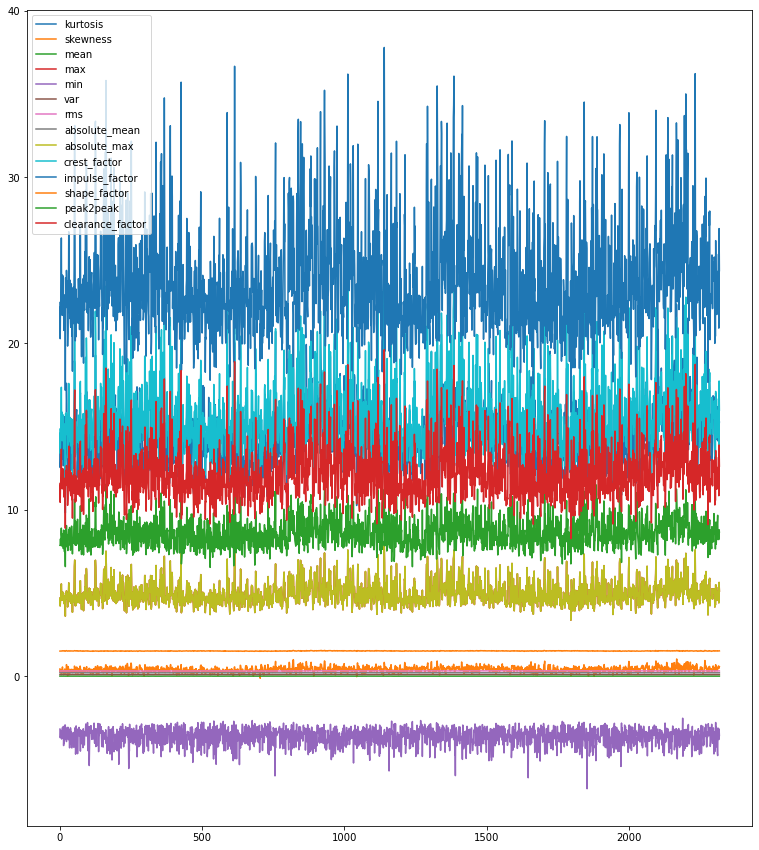

In [94]:
#visualizing all on the same scale
data.drop(columns=['label']).plot(figsize=(13,15))

#### The kurtosis contains the highest amplitude of the signals, with the crest factor also having high amplitudes
#### Some of the features have amplitudes around 0, like the max, mean,skewness
#### The min feature has amplitude way below 0

<Figure size 720x576 with 0 Axes>

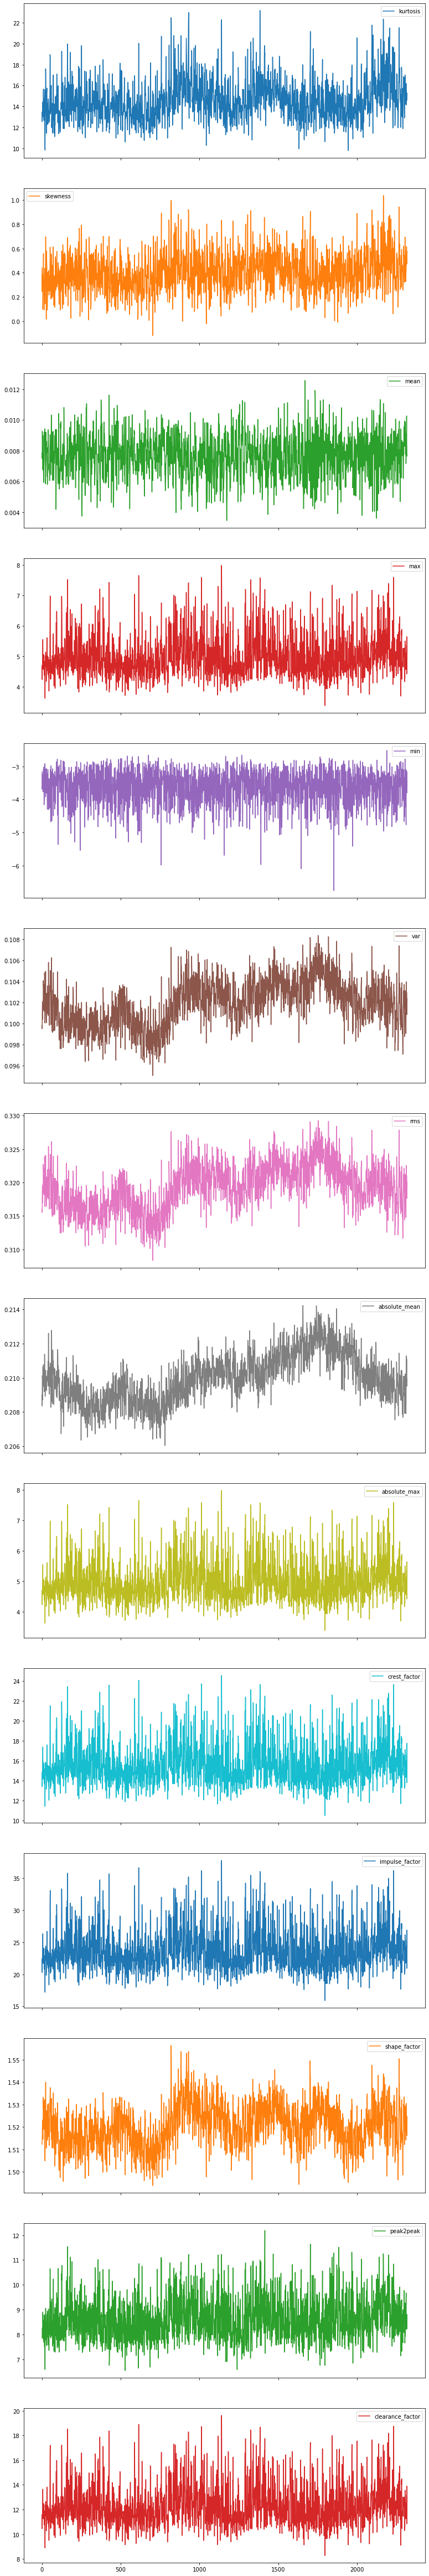

In [93]:
#visualizing them independently
plt.figure(figsize=(10,8))
data.drop(columns=['label']).plot(subplots=True,figsize=(13,85));

In [11]:
data['label'].value_counts()/len(data['label'])

2.0    0.413972
1.0    0.379474
0.0    0.206555
Name: label, dtype: float64

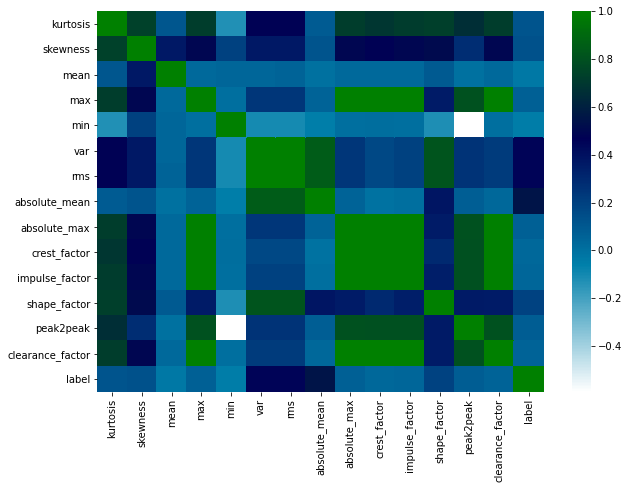

In [12]:
### correlation among features
plt.figure(figsize=(10,7))
sns.heatmap(data.corr(),cmap='ocean_r')

#### The green represents features that are highly positvely correlated with one another, with a number of them being positively correlated, but the emphasis is on the features that are correlated with the label
#### The var, rms and absolute mean have the highest positive correlation with the label, and the mean and min having the most negative correlation with the bearing fault labels

## Machine learning Modelling

In [13]:
#split data into features and label
X = data.drop(columns=['label'])
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
# Stratified Kfold cross validation
K=StratifiedKFold(n_splits=10)

### Support Vector Machine

In [14]:
svm = LinearSVC(random_state=100)
svm_acc=cross_val_score(svm,X,y,cv=K,scoring='accuracy')
svm_f1=cross_val_score(svm,X,y,cv=K,scoring='f1_weighted')
print('The 10 kfold splits average accuracy of the support vector machine model is:',np.mean(svm_acc))
print('The 10 kfold splits average f1 score of the support vector machine model is :',np.mean(svm_f1))

C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iteration

The 10 kfold splits average accuracy of the support vector machine model is: 0.41776757725033586
The 10 kfold splits average f1 score of the support vector machine model is : 0.3155366370953551


C:\Users\ampad\anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Decision Tree

In [15]:
Dt = DecisionTreeClassifier(random_state=100)
Dt_acc=cross_val_score(Dt,X,y,cv=K,scoring='accuracy')
Dt_f1=cross_val_score(Dt,X,y,cv=K,scoring='f1_weighted')
print('The 10 kfold splits average accuracy of the Decision tree model is:',np.mean(Dt_acc))
print('The 10 kfold splits average f1 score of the Decision tree model is :',np.mean(Dt_f1))

The 10 kfold splits average accuracy of the Decision tree model is: 0.4544484251380803
The 10 kfold splits average f1 score of the Decision tree model is : 0.4522279016177363


### Random Forest

In [16]:
Rf = RandomForestClassifier(random_state=100)
Rf_acc=cross_val_score(Rf,X,y,cv=K,scoring='accuracy')
Rf_f1=cross_val_score(Rf,X,y,cv=K,scoring='f1_weighted')
print('The 10 kfold splits average accuracy of the Random Forest model is:',np.mean(Rf_acc))
print('The 10 kfold splits average f1 score of the Random Forest model is :',np.mean(Rf_f1))

The 10 kfold splits average accuracy of the Random Forest model is: 0.5225369458128079
The 10 kfold splits average f1 score of the Random Forest model is : 0.516120610830163


#### Comparing the results from the models

In [17]:
#Accuracy
acc=pd.DataFrame({'Model':['Support Vector','Decision Trees','Random Forest',],
              'Accuracy':[np.mean(svm_acc),np.mean(Dt_acc),np.mean(Rf_acc)]})
acc.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
2,Random Forest,0.522537
1,Decision Trees,0.454448
0,Support Vector,0.417768


In [18]:
#F1 score
f1=pd.DataFrame({'Model':['Support Vector','Decision Trees','Random Forest',],
              'f1 score':[np.mean(svm_f1),np.mean(Dt_f1),np.mean(Rf_f1)]})
f1.sort_values(by='f1 score', ascending=False)

,Model,f1 score
2,Random Forest,0.516121
1,Decision Trees,0.452228
0,Support Vector,0.315537


#### The random forest performs better than the other models in both accuracy and F1 score, so we choose that for further modelling and analysis

### Hyperparameter tuning using the random forest model

In [19]:
forest =RandomForestClassifier()
params={
    "max_depth":[None,2,4,6,8,10],
    "n_estimators":[50,70,100,120,150],
    "criterion":['gini','entropy']}
search = RandomizedSearchCV(forest,params,cv=K,verbose=3)
search.fit(X,y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV 1/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 2/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 3/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.5s
[CV 4/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.5s
[CV 5/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 6/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 7/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 8/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.7s
[CV 9/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.6s
[CV 10/10] END criterion=entropy, max_depth=8, n_estimators=120; total time=   0.5s
[CV 1/10] END criterion=entropy, max_depth=10, n_estimators=100; total time=   0.5s
[CV 2/10] END criterio

[CV 10/10] END criterion=entropy, max_depth=8, n_estimators=100; total time=   0.4s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 2, 4, 6, 8, 10],
                                        'n_estimators': [50, 70, 100, 120,
                                                         150]},
                   verbose=3)

### Optimized Random forest model

In [20]:
Rf = RandomForestClassifier(n_estimators=120,random_state=100)
opt_Rf_acc=cross_val_score(Rf,X,y,cv=K,scoring='accuracy')
opt_Rf_f1=cross_val_score(Rf,X,y,cv=K,scoring='f1_weighted')
print('The 5 kfold splits average accuracy of the Random Forest model is:',np.mean(opt_Rf_acc))
print('The 5 kfold splits average f1 score of the Random Forest model is :',np.mean(opt_Rf_f1))

The 5 kfold splits average accuracy of the Random Forest model is: 0.5259926854754441
The 5 kfold splits average f1 score of the Random Forest model is : 0.5186216784951457


In [21]:
#accuracy
acc=pd.DataFrame({'Model':['Baseline Random forest','Optimized Random Forest'],
              'Accuracy':[np.mean(Rf_acc),np.mean(opt_Rf_acc)]})
acc.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Optimized Random Forest,0.525993
0,Baseline Random forest,0.522537


In [22]:
#f1 score
f1=pd.DataFrame({'Model':['Baseline Random forest','Optimized Random Forest'],
              'f1 score':[np.mean(Rf_f1),np.mean(opt_Rf_f1)]})
f1.sort_values(by='f1 score', ascending=False)

,Model,f1 score
1,Optimized Random Forest,0.518622
0,Baseline Random forest,0.516121


#### The most optimized Random forest model is to leave the other hyparameters the same, and change the number of trees in the forest(number of estimators) to 120
#### This beats the results of the baseline random forest

### Feature importance using the random forest model

In [23]:

def plot_feature_importance(importance,names,model_type):


  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data ={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True,)

  #Define size of bar plot
  plt.figure(figsize=(11,11))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title('FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURES')
  

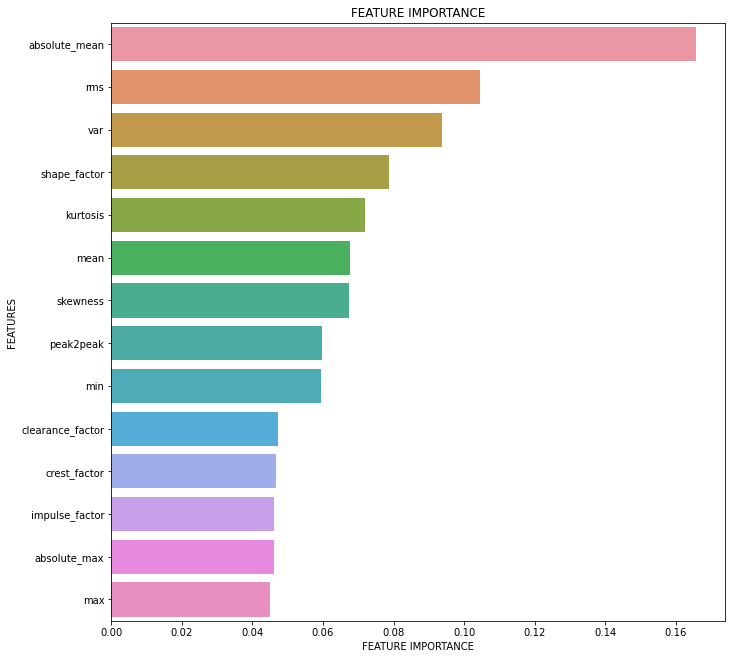

In [24]:
Rf = RandomForestClassifier(n_estimators=120,random_state=100)
Rf.fit(X_train,y_train)
Rf_pred = Rf.predict(X_test)
plot_feature_importance(Rf.feature_importances_, X.columns,'RANDOM FOREST')

#### The graph shows the features that contribute to determining bearing fault. The longer the bar, the more that feature is important in determining bearing fault
#### It can be seen that the top 3 features are , absolute mean which has the most importance, followed by var and rms
#### The max has the least importance in determining bearing fault

<Figure size 720x504 with 0 Axes>

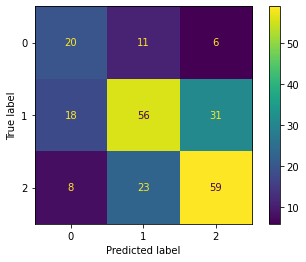

In [25]:
#confusion matrix
plt.figure(figsize=(10,7))
cm = confusion_matrix(Rf_pred,y_test)
cmd = ConfusionMatrixDisplay(cm)
cmd.plot();

#### It can be seen that bearing fault 2 had the most predictions(59) correct with bearing fault 0 having the least(20)
#### The instance when the actual fault was 1 and the model predicted 2, occurred the most times(31) among all wrong predictions(false positives and false negatives)
#### In terms of false positives alone, the model predicting 2 when it was actually 1(31 times) was the most and the model predicting  2 when it was 0 was the least(6)
#### In terms of false negatives alone, the model predicting 1 when it was actually 2(23 times) was the most and the model predicting 0 when it was actually 2 was the least(8)

## There are some features that have no relation or dont contribute to predicting the bearing fault, 

In [26]:
featureimportance_col = []
featureimportance = []

for i,column in enumerate(data.drop('label', axis = 1)):
    print('The feature importance for {} is : {}'.format(column, Rf.feature_importances_[i]))
    
    featureimportance_col.append(column)
    featureimportance.append(Rf.feature_importances_[i])

The feature importance for kurtosis is : 0.07196414046696771
The feature importance for skewness is : 0.06727349154089769
The feature importance for mean is : 0.06754337452954919
The feature importance for max is : 0.04506531130656036
The feature importance for min is : 0.05940494327581544
The feature importance for var is : 0.09380755912000784
The feature importance for rms is : 0.10439162581046052
The feature importance for absolute_mean is : 0.1657218063856361
The feature importance for absolute_max is : 0.04600378077327929
The feature importance for crest_factor is : 0.04677163356779765
The feature importance for impulse_factor is : 0.04611959573053273
The feature importance for shape_factor is : 0.078742476378512
The feature importance for peak2peak is : 0.05982322066943766
The feature importance for clearance_factor is : 0.04736704044454579


In [27]:
# Creating a Dataframe


featureimportance_dataframe = zip(featureimportance_col, featureimportance)
feat_imp_dataframe = pd.DataFrame(featureimportance_dataframe, columns = ['Feature','Feature Importance'])
feat_imp_dataframe


# Ordering the data
feat_imp_dataframe = feat_imp_dataframe.sort_values('Feature Importance', ascending = False).reset_index()

# Creating columns to keep
columns_to_keep = feat_imp_dataframe['Feature'][:9]

feat_imp_dataframe

,index,Feature,Feature Importance
0,7,absolute_mean,0.165722
1,6,rms,0.104392
2,5,var,0.093808
3,11,shape_factor,0.078742
4,0,kurtosis,0.071964
5,2,mean,0.067543
6,1,skewness,0.067273
7,12,peak2peak,0.059823
8,4,min,0.059405
9,13,clearance_factor,0.047367


#### The features with feature importance over 0.05 would be kept, and the rest discarded

In [28]:
X = data[columns_to_keep]
X.head()

,absolute_mean,rms,var,shape_factor,kurtosis,mean,skewness,peak2peak,min
0,0.208981,0.316031,0.099814,1.512248,13.450874,0.007858,0.439993,7.867432,-3.173828
1,0.208354,0.315526,0.099501,1.514376,12.542990,0.007485,0.244899,7.919312,-3.692627
2,0.210126,0.318914,0.101620,1.517729,12.963039,0.009260,0.376136,8.255005,-3.588867
3,0.209859,0.319631,0.102093,1.523071,13.835701,0.008410,0.388004,7.882690,-3.250122
4,0.208705,0.316960,0.100386,1.518697,14.406844,0.008809,0.347763,8.657837,-3.683472


In [29]:
Rf = RandomForestClassifier(n_estimators=120,random_state=100)
Opt_Rf_acc=cross_val_score(Rf,X,y,cv=K,scoring='accuracy')
Opt_Rf_f1=cross_val_score(Rf,X,y,cv=K,scoring='f1_weighted')
print('The 5 kfold splits average accuracy of the Random Forest model is:',np.mean(Opt_Rf_acc))
print('The 5 kfold splits average f1 score of the Random Forest model is :',np.mean(Opt_Rf_f1))

The 5 kfold splits average accuracy of the Random Forest model is: 0.5307489923869234
The 5 kfold splits average f1 score of the Random Forest model is : 0.5267306172210005


In [30]:
#accuracy
acc=pd.DataFrame({'Model':['Optimized Random forest','Optimized RF with imp features'],
              'Accuracy':[np.mean(opt_Rf_acc),np.mean(Opt_Rf_acc)]})
acc.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy
1,Optimized RF with imp features,0.530749
0,Optimized Random forest,0.525993


In [31]:
#f1 score
f1=pd.DataFrame({'Model':['Optimized Random forest','Optimized RF with imp features'],
              'f1 score':[np.mean(opt_Rf_f1),np.mean(Opt_Rf_f1)]})
f1.sort_values(by='f1 score', ascending=False)

,Model,f1 score
1,Optimized RF with imp features,0.526731
0,Optimized Random forest,0.518622


#### Removing the features that did not have any meaningful contribution to determining bearing fault, improved the results by almost 1.0%, which is significant to determine the bearing faults in the motors